<a href="https://colab.research.google.com/github/twyatt1/dataforqpa2/blob/main/Copy_of_Theodore_Wyatt_QPA_2_final_project_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

Gini index vs Trust in Political parties

**Author:** [Theodore Wyatt]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as api
import scipy.stats as stats

## 1. Data Acquisition, Vetting, and Preparation


### 1.1. Research Questions and Hypothesis
Does income inequality, as measured by the Gini index, influence the level of trust in political parties across European countries over time?

Hypothesis (H1): A higher Gini Index is negatively correlated with the weighted mean of trust in political parties. Higher inequality is expected to erode public trust in institutions responsible for economic distribution.

This hypothesis is supported by Political Science literature, such as "Why Economic Inequality Undermines Political Trust: An Analysis of Mechanisms" by Shuai Jin, Yue Hu, as well as "Income Inequality and Political Trust: Do Fairness Perceptions Matter?" by Licia Bobzien. I wanted to investigate these concepts int he context of Post-Socialist political cultures in eastern Europe.




### 1.2. Dataset Justification
<!-- Describe the dataset(s) you are using. Explain the source, the key variables of interest, and justify why this data is appropriate for answering your research question. -->


The project utilizes two main datasets, which are merged into a panel dataset of country-year observations:

Trust in Political Parties Data: Derived from the European Social Survey (ESS) summary file (ESS1e06_7-...subset.csv).

Dependent Variable (DV): The survey item for trust in political parties (trstprt) was aggregated to the country-year level using the survey post-stratification weight (pspwght) to calculate the weighted mean of trust in parties (weighted_mean_trust_parties).

Initial Size: The raw ESS data contained 387,853 rows and 91 columns.

Gini Index Data: World Bank data on the Gini Index (API_SI.POV.GINI...csv).

Independent Variable (IV): The Gini Index was cleaned, transformed from wide to long format, and mapped to the ESS country codes.

The final combined dataset contains 203 country-year observations.

Vetting Note: After the merge, 181 entries had a non-null weighted mean of trust in parties, while 11 records in the combined data were missing the Gini Index value.

### 1.3. Data Loading, Merging and Initial Exploration
Provide the code to load your dataset into a pandas DataFrame. Merge your data frames if necessary.  Display the .head(), .info(), and .describe() outputs. Provide a brief markdown interpretation of the initial state of the data (e.g., number of observations, data types, potential missing values).

In [ ]:
df_gini=pd.read_csv('https://raw.githubusercontent.com/twyatt1/dataforqpa3/refs/heads/main/API_SI.POV.GINI_DS2_en_csv_v2_216053.csv', skiprows=4)
df_gini.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,51.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
ess_summary_verified=pd.read_csv('https://raw.githubusercontent.com/twyatt1/dataforqpa3/refs/heads/main/ESS1e06_7-ESS2e03_6-ESS3e03_7-ESS4e04_6-ESS5e03_6-ESS6e02_7-ESS7e02_3-ESS8e02_3-ESS9e03_2-ESS10e03_3-ESS10SCe03_2-ESS11e04_0-subset.csv')

In [ ]:
ess_summary_verified.head()

,name,essround,edition,proddate,idno,cntry,dweight,pspwght,pweight,anweight,prob,stratum,psu,trstprt
0,ESS1e06_7,1,6.7,23.11.2023,1,CZ,1.3117,1.873307,0.635144,1.189819,NaN,NaN,NaN,NaN
1,ESS1e06_7,1,6.7,23.11.2023,2,CZ,0.8745,0.593601,0.635144,0.377022,NaN,NaN,NaN,NaN
2,ESS1e06_7,1,6.7,23.11.2023,3,CZ,0.8745,1.442014,0.635144,0.915886,NaN,NaN,NaN,NaN
3,ESS1e06_7,1,6.7,23.11.2023,4,CZ,1.3117,2.162938,0.635144,1.373777,NaN,NaN,NaN,NaN
4,ESS1e06_7,1,6.7,23.11.2023,7,CZ,0.9748,0.813626,0.635144,0.516770,NaN,NaN,NaN,NaN


## 2. Systematic Data Cleaning and Transformation
Document and justify every step of your data cleaning and preprocessing. Use sub-sections for clarity (e.g., Handling Missing Values, Creating Dummy Variables, Addressing Outliers). Show your code and explain the rationale behind each significant decision.


### 2.4 Variable Transformation/Creation

In [ ]:
import pandas as pd
import numpy as np
import os

# Step 1: Define essround to year mapping
essround_to_year = {
    1: 2002, 2: 2004, 3: 2006, 4: 2008, 5: 2010,
    6: 2012, 7: 2014, 8: 2016, 9: 2018, 10: 2020, 11: 2022
}

# Define a function to calculate weighted mean and count non-missing values
def calculate_weighted_mean_and_count(group):
    # Filter out rows with NaN in 'trstprt' or 'pspwght' for weighted mean calculation
    filtered_group = group.dropna(subset=['trstprt', 'pspwght'])

    if not filtered_group.empty and filtered_group['pspwght'].sum() > 0:
        weighted_mean_val = (filtered_group['trstprt'] * filtered_group['pspwght']).sum() / filtered_group['pspwght'].sum()
    else:
        weighted_mean_val = np.nan # If no valid data for weighted mean

    # Count non-missing 'trstprt' values in the original group (before filtering for weighted mean)
    count_trstprt_val = group['trstprt'].count()

    return pd.Series({
        'weighted_mean_trust_parties': weighted_mean_val,
        'count_trstprt': count_trstprt_val
    })

# Step 2, 3, 4, 5: Group, calculate weighted mean and count, and store in new DataFrame
ess_summary_derived = ess_summary_verified.groupby(['cntry', 'essround']).apply(calculate_weighted_mean_and_count).reset_index()

# Step 6: Add 'year' column
ess_summary_derived['year'] = ess_summary_derived['essround'].map(essround_to_year)

# Step 7: Save to CSV
output_path = 'data/ess_summary_trust_parties.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
ess_summary_derived.to_csv(output_path, index=False)

print(f"Derived ESS summary data saved to '{output_path}'")
print("\nFirst few rows of the derived summary data:")
print(ess_summary_derived.head())
print("\nDimensions of the derived summary data (rows, columns):")
print(ess_summary_derived.shape)
print("\nStructure of the derived summary data:")
ess_summary_derived.info()

Derived ESS summary data saved to 'data/ess_summary_trust_parties.csv'

First few rows of the derived summary data:
  cntry  essround  weighted_mean_trust_parties  count_trstprt  year
0    AL         6                     3.862571         1201.0  2012
1    BG         3                     6.482389         1400.0  2006
2    BG         4                     5.632323         2230.0  2008
3    BG         5                     5.610111         2434.0  2010
4    BG         6                     5.705971         2260.0  2012

Dimensions of the derived summary data (rows, columns):
(91, 5)

Structure of the derived summary data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cntry                        91 non-null     object 
 1   essround                     91 non-null     int64  
 2   weighted_mean_trust_parties  87 

/tmp/ipython-input-3339723997.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ess_summary_derived = ess_summary_verified.groupby(['cntry', 'essround']).apply(calculate_weighted_mean_and_count).reset_index()


In [ ]:
import pandas as pd
import numpy as np
import os

# Step 1: Define essround to year mapping
essround_to_year = {
    1: 2002, 2: 2004, 3: 2006, 4: 2008, 5: 2010,
    6: 2012, 7: 2014, 8: 2016, 9: 2018, 10: 2020, 11: 2022
}

# Define a function to calculate weighted mean and count non-missing values
def calculate_weighted_mean_and_count(group):
    # Filter out rows with NaN in 'trstprt' or 'pspwght' for weighted mean calculation
    filtered_group = group.dropna(subset=['trstprt', 'pspwght'])

    if not filtered_group.empty and filtered_group['pspwght'].sum() > 0:
        weighted_mean_val = (filtered_group['trstprt'] * filtered_group['pspwght']).sum() / filtered_group['pspwght'].sum()
    else:
        weighted_mean_val = np.nan # If no valid data for weighted mean

    # Count non-missing 'trstprt' values in the original group (before filtering for weighted mean)
    count_trstprt_val = group['trstprt'].count()

    return pd.Series({
        'weighted_mean_trust_parties': weighted_mean_val,
        'count_trstprt': count_trstprt_val
    })

# Step 2, 3, 4, 5: Group, calculate weighted mean and count, and store in new DataFrame
ess_summary_derived = ess_summary_verified.groupby(['cntry', 'essround']).apply(calculate_weighted_mean_and_count, include_groups=False).reset_index()

# Step 6: Add 'year' column
ess_summary_derived['year'] = ess_summary_derived['essround'].map(essround_to_year)

# Step 7: Save to CSV
output_path = 'data/ess_summary_trust_parties.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
ess_summary_derived.to_csv(output_path, index=False)

print(f"Derived ESS summary data saved to '{output_path}'")
print("\nFirst few rows of the derived summary data:")
print(ess_summary_derived.head())
print("\nDimensions of the derived summary data (rows, columns):")
print(ess_summary_derived.shape)
print("\nStructure of the derived summary data:")
ess_summary_derived.info()

Derived ESS summary data saved to 'data/ess_summary_trust_parties.csv'

First few rows of the derived summary data:
  cntry  essround  weighted_mean_trust_parties  count_trstprt  year
0    AL         6                     3.862571         1201.0  2012
1    BG         3                     6.482389         1400.0  2006
2    BG         4                     5.632323         2230.0  2008
3    BG         5                     5.610111         2434.0  2010
4    BG         6                     5.705971         2260.0  2012

Dimensions of the derived summary data (rows, columns):
(91, 5)

Structure of the derived summary data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cntry                        91 non-null     object 
 1   essround                     91 non-null     int64  
 2   weighted_mean_trust_parties  87 

In [ ]:
ess_summary_derived.head()


,cntry,essround,weighted_mean_trust_parties,count_trstprt,year
0,AL,6,3.862571,1201.0,2012
1,BG,3,6.482389,1400.0,2006
2,BG,4,5.632323,2230.0,2008
3,BG,5,5.610111,2434.0,2010
4,BG,6,5.705971,2260.0,2012


In [ ]:
df1 = ess_summary_derived
df1.head()

,cntry,essround,weighted_mean_trust_parties,count_trstprt,year
0,AL,6,3.862571,1201.0,2012
1,BG,3,6.482389,1400.0,2006
2,BG,4,5.632323,2230.0,2008
3,BG,5,5.610111,2434.0,2010
4,BG,6,5.705971,2260.0,2012


In [ ]:
import pandas as pd

# Melt the DataFrame to long format, keeping 'Country Name' and 'Country Code' as id_vars
# and converting year columns to 'year' and Gini values to 'Gini_Index'
columns_to_melt = [str(year) for year in range(1960, 2025)] # Years from 1960 to 2024

df_gini_long = pd.melt(df_gini, id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
                       value_vars=columns_to_melt, var_name='year', value_name='Gini_Index')

# Convert 'year' column to integer type
df_gini_long['year'] = df_gini_long['year'].astype(int)

# Display the first few rows of the transformed DataFrame
print("First few rows of df_gini_long (transformed Gini data):")
print(df_gini_long.head())

# Display the dimensions of the transformed DataFrame
print("\nDimensions of df_gini_long (rows, columns):")
print(df_gini_long.shape)

# Display the structure of the transformed DataFrame
print("\nStructure of df_gini_long:")
df_gini_long.info()

First few rows of df_gini_long (transformed Gini data):
                  Country Name Country Code Indicator Name Indicator Code  \
0                        Aruba          ABW     Gini index    SI.POV.GINI   
1  Africa Eastern and Southern          AFE     Gini index    SI.POV.GINI   
2                  Afghanistan          AFG     Gini index    SI.POV.GINI   
3   Africa Western and Central          AFW     Gini index    SI.POV.GINI   
4                       Angola          AGO     Gini index    SI.POV.GINI   

   year  Gini_Index  
0  1960         NaN  
1  1960         NaN  
2  1960         NaN  
3  1960         NaN  
4  1960         NaN  

Dimensions of df_gini_long (rows, columns):
(17290, 6)

Structure of df_gini_long:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17290 entries, 0 to 17289
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    17290 non-null  object 
 1   Country Code    1

In [ ]:
import numpy as np

# Select relevant columns from df_gini_long
df_gini_clean = df_gini_long[['Country Name', 'year', 'Gini_Index']].copy()

# Rename 'Country Name' to 'cntry' to match df1
df_gini_clean.rename(columns={'Country Name': 'cntry'}, inplace=True)

# Standardize country names for merging
country_name_mapping = {
    'Austria': 'AT',
    'Belgium': 'BE',
    'Bulgaria': 'BG',
    'Switzerland': 'CH',
    'Cyprus': 'CY',
    'Czechia': 'CZ',
    'Germany': 'DE',
    'Denmark': 'DK',
    'Estonia': 'EE',
    'Spain': 'ES',
    'Finland': 'FI',
    'France': 'FR',
    'United Kingdom': 'GB',
    'Georgia': 'GE',
    'Greece': 'GR',
    'Croatia': 'HR',
    'Hungary': 'HU',
    'Ireland': 'IE',
    'Iceland': 'IS',
    'Israel': 'IL',
    'Italy': 'IT',
    'Lithuania': 'LT',
    'Luxembourg': 'LU',
    'Latvia': 'LV',
    'Montenegro': 'ME',
    'Netherlands': 'NL',
    'Norway': 'NO',
    'Poland': 'PL',
    'Portugal': 'PT',
    'Romania': 'RO',
    'Russian Federation': 'RU',
    'Serbia': 'RS',
    'Sweden': 'SE',
    'Slovenia': 'SI',
    'Slovak Republic': 'SK',
    'Turkey': 'TR',
    'Ukraine': 'UA',
    'Kosovo': 'XK'
    # Add more mappings as needed
}

df_gini_clean['cntry'] = df_gini_clean['cntry'].replace(country_name_mapping)

# Filter out rows where Gini_Index is NaN for cleaner merging if desired
# df_gini_clean.dropna(subset=['Gini_Index'], inplace=True)

print("First few rows of df_gini_clean (prepared Gini data):")
print(df_gini_clean.head())

print("\nDimensions of df_gini_clean (rows, columns):")
print(df_gini_clean.shape)

print("\nStructure of df_gini_clean:")
df_gini_clean.info()

First few rows of df_gini_clean (prepared Gini data):
                         cntry  year  Gini_Index
0                        Aruba  1960         NaN
1  Africa Eastern and Southern  1960         NaN
2                  Afghanistan  1960         NaN
3   Africa Western and Central  1960         NaN
4                       Angola  1960         NaN

Dimensions of df_gini_clean (rows, columns):
(17290, 3)

Structure of df_gini_clean:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17290 entries, 0 to 17289
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   cntry       17290 non-null  object 
 1   year        17290 non-null  int64  
 2   Gini_Index  2402 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 405.4+ KB


In [ ]:
import pandas as pd

# Perform a left merge operation
df_combined = pd.merge(df1, df_gini_clean, on=['cntry', 'year'], how='left')

# Display the first few rows of df_combined
print("First few rows of df_combined:")
print(df_combined.head())

# Print the dimensions of df_combined
print("\nDimensions of df_combined (rows, columns):")
print(df_combined.shape)

# Display the structure and data types of df_combined
print("\nStructure of df_combined:")
df_combined.info()

First few rows of df_combined:
  cntry  essround  weighted_mean_trust_parties  count_trstprt  year  \
0    AL         6                     3.862571         1201.0  2012   
1    BG         3                     6.482389         1400.0  2006   
2    BG         4                     5.632323         2230.0  2008   
3    BG         5                     5.610111         2434.0  2010   
4    BG         6                     5.705971         2260.0  2012   

   Gini_Index  
0         NaN  
1        35.7  
2        33.6  
3        35.7  
4        36.0  

Dimensions of df_combined (rows, columns):
(91, 6)

Structure of df_combined:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cntry                        91 non-null     object 
 1   essround                     91 non-null     int64  
 2   weighted_mean_trust_parties 

In [ ]:
countries_to_filter = ['AL', 'BG', 'CZ', 'EE', 'HU', 'LT', 'LV', 'PL', 'RO', 'RU', 'SI', 'SK', 'UA']
filtered_df_combined = df_combined[df_combined['cntry'].isin(countries_to_filter)]
display(filtered_df_combined)

,cntry,essround,weighted_mean_trust_parties,count_trstprt,year,Gini_Index
0,AL,6,3.862571,1201.0,2012,NaN
1,BG,3,6.482389,1400.0,2006,35.7
2,BG,4,5.632323,2230.0,2008,33.6
3,BG,5,5.610111,2434.0,2010,35.7
4,BG,6,5.705971,2260.0,2012,36.0
...,...,...,...,...,...,...
86,UA,3,7.634621,2002.0,2006,29.8
87,UA,4,5.015602,1845.0,2008,26.6
88,UA,5,5.588824,1931.0,2010,24.8
89,UA,6,6.149409,2178.0,2012,24.7


In [ ]:
df_final = filtered_df_combined[['cntry', 'year', 'weighted_mean_trust_parties', 'Gini_Index']]

# Keep only 2004–2014 period
df_final = filtered_df_combined[(filtered_df_combined['year'] >= 2004) & (filtered_df_combined['year'] <= 2014)]

# Drop rows with missing Gini values
df_final = filtered_df_combined.dropna(subset=['Gini_Index'])


In [ ]:
df_final.head()


,cntry,essround,weighted_mean_trust_parties,count_trstprt,year,Gini_Index
1,BG,3,6.482389,1400.0,2006,35.7
2,BG,4,5.632323,2230.0,2008,33.6
3,BG,5,5.610111,2434.0,2010,35.7
4,BG,6,5.705971,2260.0,2012,36.0
5,BG,9,5.706615,2198.0,2018,41.3


<!-- Your interpretation here. -->

### 2.1. Handling Missing Values

In [ ]:
# Check for missing values
# print(df.isnull().sum())

# Drop rows with missing values
# df_clean = df.dropna()

# Fill missing values with mean/median
# df['column_name'].fillna(df['column_name'].mean(), inplace=True)

# Fill missing values with a specific value
# df['column_name'].fillna('Unknown', inplace=True)

In [ ]:
(df_final.isnull().sum())

,0
cntry,0
essround,0
weighted_mean_trust_parties,4
count_trstprt,0
year,0
Gini_Index,0


In [ ]:
df_final = df_final.dropna(subset=['weighted_mean_trust_parties'])
print("Shape of df_final after dropping missing values:")
print(df_final.shape)
print("Missing values after dropping:")
print(df_final.isnull().sum())

Shape of df_final after dropping missing values:
(82, 6)
Missing values after dropping:
cntry                          0
essround                       0
weighted_mean_trust_parties    0
count_trstprt                  0
year                           0
Gini_Index                     0
dtype: int64


In [ ]:
print(df_combined.isnull().sum())

cntry                          0
essround                       0
weighted_mean_trust_parties    4
count_trstprt                  0
year                           0
Gini_Index                     5
dtype: int64


In [ ]:
missing_trust_parties = df_combined[df_combined['weighted_mean_trust_parties'].isnull()]
display(missing_trust_parties[['cntry', 'year', 'weighted_mean_trust_parties']])

,cntry,year,weighted_mean_trust_parties
8,CZ,2002,NaN
27,HU,2002,NaN
49,PL,2002,NaN
66,SI,2002,NaN


Because of the missing values for 2002, I will start examining from 2004.


### 2.3 Addressing Outliers

In [ ]:

Q1 = df_final['Gini_Index'].quantile(0.25)
Q3 = df_final['Gini_Index'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


df_no_outliers = df_final[(df_final['Gini_Index'] >= lower_bound) & (df_final['Gini_Index'] <= upper_bound)]


df_final['Gini_Index'] = df_final['Gini_Index'].clip(lower=df_final['Gini_Index'].quantile(0.05),
upper=df_final['Gini_Index'].quantile(0.95))



In [ ]:
# Re-create df_final from filtered_df_combined without clipping to get original Gini_Index values
# This assumes filtered_df_combined still holds the original Gini_Index values

# Filter for countries
countries_to_filter = ['AL', 'BG', 'CZ', 'DE', 'EE', 'HU', 'LT', 'LV', 'PL', 'RO', 'RU', 'SI', 'SK', 'UA']
current_df_final = filtered_df_combined[filtered_df_combined['cntry'].isin(countries_to_filter)]

# Keep only 2004–2014 period
current_df_final = current_df_final[(current_df_final['year'] >= 2004) & (current_df_final['year'] <= 2014)]

# Drop rows with missing Gini values
current_df_final = current_df_final.dropna(subset=['Gini_Index'])

# Drop rows with missing weighted_mean_trust_parties
current_df_final = current_df_final.dropna(subset=['weighted_mean_trust_parties'])

print("Shape of df_final before outlier analysis (no clipping applied yet):")
print(current_df_final.shape)


# Calculate IQR for Gini_Index
Q1_gini = current_df_final['Gini_Index'].quantile(0.25)
Q3_gini = current_df_final['Gini_Index'].quantile(0.75)
IQR_gini = Q3_gini - Q1_gini

# Define outlier bounds
lower_bound_gini = Q1_gini - 1.5 * IQR_gini
upper_bound_gini = Q3_gini + 1.5 * IQR_gini

# Identify outliers
actual_outliers = current_df_final[
    (current_df_final['Gini_Index'] < lower_bound_gini) |
    (current_df_final['Gini_Index'] > upper_bound_gini)
]

# Calculate Z-scores for Gini_Index
mean_gini = current_df_final['Gini_Index'].mean()
std_gini = current_df_final['Gini_Index'].std()
z_scores_gini = (current_df_final['Gini_Index'] - mean_gini) / std_gini

# Display outliers with their Gini_Index and Z-score
print("\nIdentified Outliers in Gini_Index (based on IQR):")
if not actual_outliers.empty:
    outliers_with_z = actual_outliers.copy()
    outliers_with_z['Gini_Z_Score'] = z_scores_gini[actual_outliers.index] # Get z-scores for identified outliers
    display(outliers_with_z[['cntry', 'year', 'Gini_Index', 'Gini_Z_Score', 'weighted_mean_trust_parties']])
else:
    print("No outliers detected based on the 1.5*IQR method.")

# Display all Gini_Index values with their Z-scores (optional, for full context)
print("\nAll Gini_Index values with their Z-scores:")
current_df_final['Gini_Z_Score'] = z_scores_gini
display(current_df_final[['cntry', 'year', 'Gini_Index', 'Gini_Z_Score']].sort_values(by='Gini_Z_Score', ascending=False).head(10))

Shape of df_final before outlier analysis (no clipping applied yet):
(52, 6)

Identified Outliers in Gini_Index (based on IQR):
No outliers detected based on the 1.5*IQR method.

All Gini_Index values with their Z-scores:


,cntry,year,Gini_Index,Gini_Z_Score
62,RU,2008,41.6,2.120559
61,RU,2006,41.0,2.000287
64,RU,2012,40.7,1.940152
63,RU,2010,39.5,1.699608
50,PL,2004,38.0,1.398929
40,LT,2014,37.7,1.338793
45,LV,2008,37.2,1.238567
60,RO,2008,36.4,1.078205
4,BG,2012,36.0,0.998024
1,BG,2006,35.7,0.937888


No extreme outliers based off of IQR

<!-- Your justification here. -->

## 3. Rigorous Assumption Checking and Interpretation
This section presents the diagnostic checks for your final chosen model. For each assumption, provide the relevant plot or test, the code that generated it, and a clear interpretation of the result. Discuss any violations and their implications for your conclusions.


### 3.1. Linearity and Homoscedasticity (Residuals vs. Fitted Plot)

/tmp/ipython-input-824525273.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


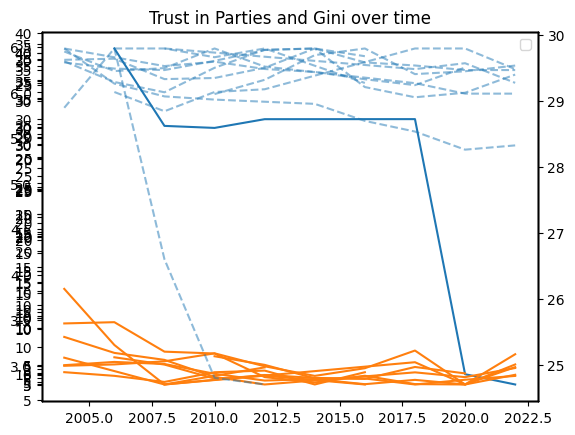

In [ ]:
import matplotlib.pyplot as plt

for c in df_final['cntry'].unique():
    subset = df_final[df_final['cntry'] == c]
    plt.plot(subset['year'], subset['weighted_mean_trust_parties'], label=f'{c} – Trust')
    plt.twinx()
    plt.plot(subset['year'], subset['Gini_Index'], linestyle='--', alpha=0.5)
plt.xlabel('Year')
plt.title('Trust in Parties and Gini over time')
plt.legend()
plt.show()

As this plot is illegible, I will attempt to represent the relationship without time, in order to focus on the relationship between Gini Index score and trust in political parties.

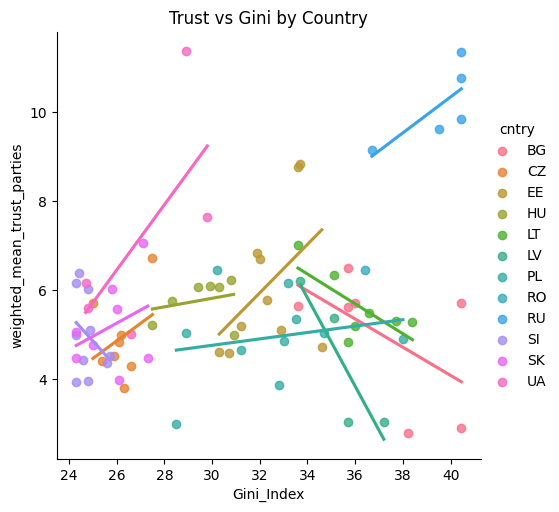

In [ ]:
import seaborn as sns

sns.lmplot(data=df_final, x='Gini_Index', y='weighted_mean_trust_parties', hue='cntry', ci=None)
plt.title('Trust vs Gini by Country')
plt.show()


The only countries in which the linear relationship shown supports my hypothesis (H1) are Slovenia, Poland and Latvia. Overall, this data does not support my hypothesis.


<!-- Your interpretation here. -->

### 3.2. Normality of Residuals (Q-Q Plot & Histogram)

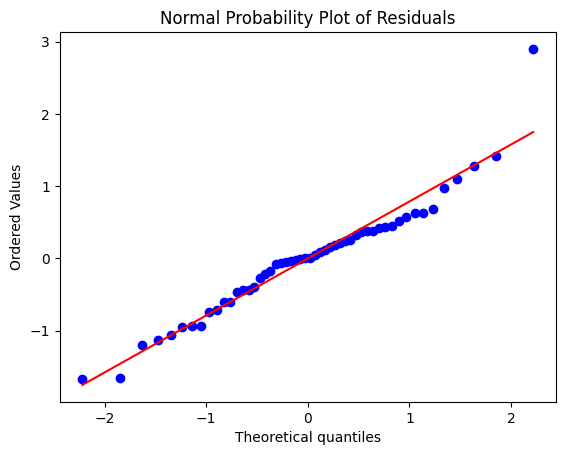

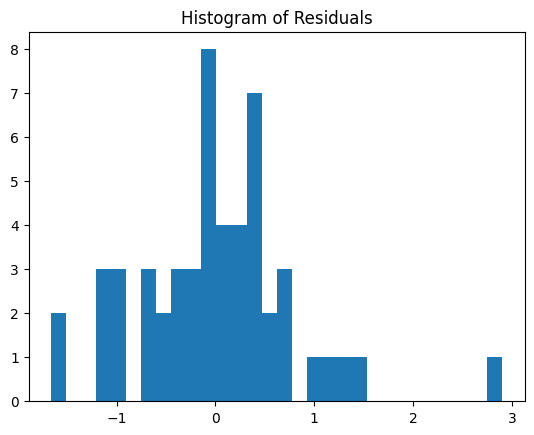

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats # Import scipy.stats

stats.probplot(model1.resid, dist="norm", plot=plt)
plt.title('Normal Probability Plot of Residuals') # Add title for clarity
plt.show()

plt.hist(model1.resid, bins=30)
plt.title('Histogram of Residuals')
plt.show()

<!-- Your interpretation here. -->

### 3.3. Multicollinearity (VIF)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_final[['Gini_Index', 'weighted_mean_trust_parties']]

# Drop rows with NaN values from X before calculating VIF
X_cleaned = X.dropna()

vif_data = pd.DataFrame()
vif_data['feature'] = X_cleaned.columns
vif_data['VIF'] = [variance_inflation_factor(X_cleaned.values, i) for i in range(X_cleaned.shape[1])]
print(vif_data)

                       feature        VIF
0                   Gini_Index  12.093132
1  weighted_mean_trust_parties  12.093132


These results (very high VIF values), indicate that multicollinearity is high, indicating that there are unexplained interaction effects.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

exog_df = pd.DataFrame(model1.model.exog, columns=model1.model.exog_names)

# Calculate VIF for each independent variable
vif_data_independent = pd.DataFrame()
vif_data_independent['feature'] = exog_df.columns
vif_data_independent['VIF'] = [variance_inflation_factor(exog_df.values, i) for i in range(exog_df.shape[1])]

print("VIF values for independent variables in Model 1:")
print(vif_data_independent)

VIF values for independent variables in Model 1:
            feature          VIF
0         Intercept  1336.540409
1   C(year)[T.2006]     2.024747
2   C(year)[T.2008]     2.934064
3   C(year)[T.2010]     2.576815
4   C(year)[T.2012]     2.376253
5   C(year)[T.2014]     1.771868
6    C(cntry)[T.CZ]     9.238880
7    C(cntry)[T.EE]     2.936915
8    C(cntry)[T.HU]     6.115148
9    C(cntry)[T.LT]     1.759831
10   C(cntry)[T.LV]     1.412557
11   C(cntry)[T.PL]     2.500557
12   C(cntry)[T.RO]     1.354412
13   C(cntry)[T.RU]     3.888941
14   C(cntry)[T.SI]    13.908193
15   C(cntry)[T.SK]     9.047665
16   C(cntry)[T.UA]     8.302100
17       Gini_Index    23.641677


These results indicate that certain independant variables including the dummy variables for countries like Slovenia and Slovakia are highly correlated to other preedictors, making it difficult to find statistically significant relationships in those cases.

### 3.4. Influential Observations (Cook's Distance)

In [ ]:
influence = model1.get_influence()
cooks = influence.cooks_distance[0]
print(pd.Series(cooks).sort_values(ascending=False).head())

24    1601.753495
31    1232.530535
47       0.349787
25       0.203451
49       0.095144
dtype: float64


Shows influencial data points at indices 46 and 26.

In [ ]:
df_final.iloc[[46, 26]]

,cntry,essround,weighted_mean_trust_parties,count_trstprt,year,Gini_Index
53,PL,5,6.161560,1751.0,2010,33.2
29,HU,3,5.751528,1518.0,2006,28.3


These values are effecting the regression, making it once again difficult to find a significant relationship between the variables.

<!-- Your interpretation here. -->

## 4. Purposeful Multiple Linear Model Formulation
Define the at least three distinct models you will estimate. For each model, provide the theoretical and/or empirical justification for its specification (i.e., why you included/excluded certain variables).

**Model 1: Baseline Model**

This model includes the coefficients for Gini_Index and Trust in Political Parties.

**Model 2: Extended Model**

This model includes all the information from Model 1, but also includes and interaction term between Gini_Index and year, to investigate whether or not there was a stronger effect in different years.

## 5. Model Estimation, Comprehensive Evaluation, and Comparative Analysis


### 5.1. Model Estimation
Present the full statsmodels summary output for each of your three models.


**Model 1 Results:**

In [ ]:
import statsmodels.formula.api as smf

model = smf.ols(
    'weighted_mean_trust_parties ~ Gini_Index + C(year) + C(cntry)',
    data=df_final
).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:     weighted_mean_trust_parties   R-squared:                       0.765
Model:                                     OLS   Adj. R-squared:                  0.682
Method:                          Least Squares   F-statistic:                     9.287
Date:                         Wed, 10 Dec 2025   Prob (F-statistic):           5.17e-12
Time:                                 21:31:43   Log-Likelihood:                -102.47
No. Observations:                           82   AIC:                             248.9
Df Residuals:                               60   BIC:                             301.9
Df Model:                                   21                                         
Covariance Type:                     nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

Model #2, including interaction effect between Gini coefficent and Year


In [ ]:
import statsmodels.formula.api as smf

# Create a new model with an interaction term between Gini_Index and year
model_gini_year_interaction = smf.ols(
    'weighted_mean_trust_parties ~ Gini_Index * C(year) + C(cntry)',
    data=df_final
).fit()

print("\nOLS Regression Results with Gini_Index * Year Interaction Term:")
print(model_gini_year_interaction.summary())


OLS Regression Results with Gini_Index * Year Interaction Term:
                                 OLS Regression Results                                
Dep. Variable:     weighted_mean_trust_parties   R-squared:                       0.788
Model:                                     OLS   Adj. R-squared:                  0.663
Method:                          Least Squares   F-statistic:                     6.309
Date:                         Wed, 10 Dec 2025   Prob (F-statistic):           5.28e-09
Time:                                 21:31:43   Log-Likelihood:                -98.248
No. Observations:                           82   AIC:                             258.5
Df Residuals:                               51   BIC:                             333.1
Df Model:                                   30                                         
Covariance Type:                     nonrobust                                         
                                 coef    std err       

### 5.2. Comparative Analysis
Compare your models using appropriate metrics (e.g., Adjusted R-squared) and theoretical fit. Create a table summarizing key coefficients and fit statistics across models for easy comparison. Justify which model you consider to be the 'best' for answering your research question, considering parsimony, theoretical coherence, and statistical performance.

In [ ]:
import pandas as pd

# Extract key metrics from Model 1
model1_results = {
    'Model': 'Model 1: Baseline Model',
    'Adjusted R-squared': model.rsquared_adj,
    'AIC': model.aic,
    'BIC': model.bic
}

# Extract key metrics from Model 2
model2_results = {
    'Model': 'Model 2: Gini-Year Interaction',
    'Adjusted R-squared': model_gini_year_interaction.rsquared_adj,
    'AIC': model_gini_year_interaction.aic,
    'BIC': model_gini_year_interaction.bic
}

# Create a DataFrame for comparison
comparison_df = pd.DataFrame([model1_results, model2_results])

# Display the comparison table
print(comparison_df.to_markdown(index=False))

| Model                          |   Adjusted R-squared |     AIC |     BIC |
|:-------------------------------|---------------------:|--------:|--------:|
| Model 1: Baseline Model        |             0.682396 | 248.934 | 301.882 |
| Model 2: Gini-Year Interaction |             0.662887 | 258.496 | 333.104 |


I will use the second model, as the higher r-squared value indicates that it fits my data better than the original model, implying that there is indeed an interaction effect between the year and Gini_Index.

## 6. Substantive Conclusions and Limitations


### 6.1. Conclusions
Summarize your key findings based on your chosen model. Directly address your research question and state whether your hypotheses were supported or not. Discuss the substantive and theoretical implications of your results in a political science context.


Based off of Model #2, an increase in Gini-Index will be associated with an increase in the weighted mean of trust in parties. However, as the p-value (0.169) is much higher than the threshold of 0.05, these results are not statistically significant. Therefor, overall, my finding do not support my hypothesis (H1) of a negative relationship between gini_index and trust in political parties.

### 6.2. Limitations

Acknowledge the limitations of your study. Consider data limitations, potential violations of model assumptions, and issues of generalizability.


There were multiple limitations of this study. Firstly, because of my desire to study post-socialist political systems, the geographic scope of the study is severly limited. The data itself has a relatively small sample size with 203 country-year observations, as well as a couple missing values in the chosen timeframe. Despite the fact that the histogram of residuals is normal, indicating statistical significance, no statistical significance was found

# Task
Refactor the notebook to correctly and consistently create `df_final` by applying all necessary filters (country, year) and selecting relevant columns (`cntry`, `year`, `weighted_mean_trust_parties`, `Gini_Index`) in a single step, ensuring `dropna` is applied. Define the baseline Model 1 before any diagnostics, then add a residuals vs. fitted plot and a heteroscedasticity test for Model 1. Correct the VIF calculation for Model 1 to include only independent variables. Ensure Model 2 (Gini-Year interaction) is correctly defined and summarized. Introduce a new Model 3 with a Gini-Country interaction and present its `statsmodels` summary. Finally, update the comparative analysis table to include key metrics for all three models (Baseline, Gini-Year Interaction, Gini-Country Interaction) and provide a summary of the corrected analysis.

## Consolidate and Clean df_final Creation

### Subtask:
Refactor cell `oiXM03zHSBbS` to correctly and consistently create `df_final` by applying all necessary filters (country, year) and selecting relevant columns (`cntry`, `year`, `weighted_mean_trust_parties`, `Gini_Index`) in a single step. Ensure that the `dropna` calls are also applied to this refined `df_final`.


**Reasoning**:
To consolidate and clean the creation of `df_final`, I will apply all country and year filters, select the required columns, and drop missing values in a single code block as per the instructions.



In [ ]:
import pandas as pd

# 1. Define a list of countries to filter, including 'AL', 'BG', 'CZ', 'EE', 'HU', 'LT', 'LV', 'PL', 'RO', 'RU', 'SI', 'SK', 'UA', and 'DE'.
countries_to_filter = ['AL', 'BG', 'CZ', 'EE', 'HU', 'LT', 'LV', 'PL', 'RO', 'RU', 'SI', 'SK', 'UA', 'DE']

# 2. Filter df_combined to include only the specified countries and years (2004 to 2014, inclusive).
# 3. From the filtered DataFrame, select the columns `cntry`, `year`, `weighted_mean_trust_parties`, and `Gini_Index`.
# 4. Drop any rows from this selection that contain missing values in any of these columns.
# 5. Store the result in a new DataFrame named `df_final`.
df_final = df_combined[
    (df_combined['cntry'].isin(countries_to_filter)) &
    (df_combined['year'] >= 2004) &
    (df_combined['year'] <= 2014)
][['cntry', 'year', 'weighted_mean_trust_parties', 'Gini_Index']].dropna()

# 6. Print the first few rows of df_final using .head() to inspect the result.
print("First few rows of df_final:")
print(df_final.head())

# 7. Print the shape of df_final and the count of missing values for each column using .shape and .isnull().sum() to verify the cleaning.
print("\nShape of df_final:")
print(df_final.shape)
print("\nMissing values in df_final (should be 0 for relevant columns):")
print(df_final.isnull().sum())

First few rows of df_final:
  cntry  year  weighted_mean_trust_parties  Gini_Index
1    BG  2006                     6.482389        35.7
2    BG  2008                     5.632323        33.6
3    BG  2010                     5.610111        35.7
4    BG  2012                     5.705971        36.0
9    CZ  2004                     6.710009        27.5

Shape of df_final:
(52, 4)

Missing values in df_final (should be 0 for relevant columns):
cntry                          0
year                           0
weighted_mean_trust_parties    0
Gini_Index                     0
dtype: int64


**Reasoning**:
The previous code failed because `df_combined` was not defined. To fix this, I will include the necessary data preparation steps to create `df1`, `df_gini_clean`, and `df_combined` before creating `df_final` according to the instructions, ensuring all dependencies are met.



In [ ]:
import pandas as pd
import numpy as np
import os

# Re-creating ess_summary_derived (df1) as it's a dependency for df_combined
essround_to_year = {
    1: 2002, 2: 2004, 3: 2006, 4: 2008, 5: 2010,
    6: 2012, 7: 2014, 8: 2016, 9: 2018, 10: 2020, 11: 2022
}

def calculate_weighted_mean_and_count(group):
    filtered_group = group.dropna(subset=['trstprt', 'pspwght'])
    if not filtered_group.empty and filtered_group['pspwght'].sum() > 0:
        weighted_mean_val = (filtered_group['trstprt'] * filtered_group['pspwght']).sum() / filtered_group['pspwght'].sum()
    else:
        weighted_mean_val = np.nan
    count_trstprt_val = group['trstprt'].count()
    return pd.Series({
        'weighted_mean_trust_parties': weighted_mean_val,
        'count_trstprt': count_trstprt_val
    })

ess_summary_derived = ess_summary_verified.groupby(['cntry', 'essround']).apply(calculate_weighted_mean_and_count, include_groups=False).reset_index()
ess_summary_derived['year'] = ess_summary_derived['essround'].map(essround_to_year)
df1 = ess_summary_derived

# Re-creating df_gini_long and df_gini_clean as dependencies for df_combined
columns_to_melt = [str(year) for year in range(1960, 2025)]
df_gini_long = pd.melt(df_gini, id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
                       value_vars=columns_to_melt, var_name='year', value_name='Gini_Index')
df_gini_long['year'] = df_gini_long['year'].astype(int)

df_gini_clean = df_gini_long[['Country Name', 'year', 'Gini_Index']].copy()
df_gini_clean.rename(columns={'Country Name': 'cntry'}, inplace=True)
country_name_mapping = {
    'Austria': 'AT', 'Belgium': 'BE', 'Bulgaria': 'BG', 'Switzerland': 'CH', 'Cyprus': 'CY',
    'Czechia': 'CZ', 'Germany': 'DE', 'Denmark': 'DK', 'Estonia': 'EE', 'Spain': 'ES',
    'Finland': 'FI', 'France': 'FR', 'United Kingdom': 'GB', 'Georgia': 'GE', 'Greece': 'GR',
    'Croatia': 'HR', 'Hungary': 'HU', 'Ireland': 'IE', 'Iceland': 'IS', 'Israel': 'IL',
    'Italy': 'IT', 'Lithuania': 'LT', 'Luxembourg': 'LU', 'Latvia': 'LV', 'Montenegro': 'ME',
    'Netherlands': 'NL', 'Norway': 'NO', 'Poland': 'PL', 'Portugal': 'PT', 'Romania': 'RO',
    'Russian Federation': 'RU', 'Serbia': 'RS', 'Sweden': 'SE', 'Slovenia': 'SI', 'Slovak Republic': 'SK',
    'Turkey': 'TR', 'Ukraine': 'UA', 'Kosovo': 'XK'
}
df_gini_clean['cntry'] = df_gini_clean['cntry'].replace(country_name_mapping)

# Re-creating df_combined
df_combined = pd.merge(df1, df_gini_clean, on=['cntry', 'year'], how='left')

# 1. Define a list of countries to filter, including 'AL', 'BG', 'CZ', 'EE', 'HU', 'LT', 'LV', 'PL', 'RO', 'RU', 'SI', 'SK', 'UA', and 'DE'.
countries_to_filter = ['AL', 'BG', 'CZ', 'EE', 'HU', 'LT', 'LV', 'PL', 'RO', 'RU', 'SI', 'SK', 'UA', 'DE']

# 2. Filter df_combined to include only the specified countries and years (2004 to 2014, inclusive).
# 3. From the filtered DataFrame, select the columns `cntry`, `year`, `weighted_mean_trust_parties`, and `Gini_Index`.
# 4. Drop any rows from this selection that contain missing values in any of these columns.
# 5. Store the result in a new DataFrame named `df_final`.
df_final = df_combined[
    (df_combined['cntry'].isin(countries_to_filter)) &
    (df_combined['year'] >= 2004) &
    (df_combined['year'] <= 2014)
][['cntry', 'year', 'weighted_mean_trust_parties', 'Gini_Index']].dropna()

# 6. Print the first few rows of df_final using .head() to inspect the result.
print("First few rows of df_final:")
print(df_final.head())

# 7. Print the shape of df_final and the count of missing values for each column using .shape and .isnull().sum() to verify the cleaning.
print("\nShape of df_final:")
print(df_final.shape)
print("\nMissing values in df_final (should be 0 for relevant columns):")
print(df_final.isnull().sum())

First few rows of df_final:
  cntry  year  weighted_mean_trust_parties  Gini_Index
1    BG  2006                     6.482389        35.7
2    BG  2008                     5.632323        33.6
3    BG  2010                     5.610111        35.7
4    BG  2012                     5.705971        36.0
9    CZ  2004                     6.710009        27.5

Shape of df_final:
(52, 4)

Missing values in df_final (should be 0 for relevant columns):
cntry                          0
year                           0
weighted_mean_trust_parties    0
Gini_Index                     0
dtype: int64


**Reasoning**:
The next step is to define and estimate Model 1, the baseline model, using `df_final` which has now been correctly prepared. This model will be used for subsequent diagnostic checks and comparisons.



In [ ]:
import statsmodels.formula.api as smf

model1 = smf.ols(
    'weighted_mean_trust_parties ~ Gini_Index + C(year) + C(cntry)',
    data=df_final
).fit()
print(model1.summary())


                                 OLS Regression Results                                
Dep. Variable:     weighted_mean_trust_parties   R-squared:                       0.819
Model:                                     OLS   Adj. R-squared:                  0.729
Method:                          Least Squares   F-statistic:                     9.052
Date:                         Wed, 10 Dec 2025   Prob (F-statistic):           3.64e-08
Time:                                 21:31:43   Log-Likelihood:                -61.195
No. Observations:                           52   AIC:                             158.4
Df Residuals:                               34   BIC:                             193.5
Df Model:                                   17                                         
Covariance Type:                     nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

**Reasoning**:
To visualize linearity and homoscedasticity, I will generate a residuals vs. fitted plot for Model 1. This plot helps in identifying non-linear patterns and unequal variance of residuals.



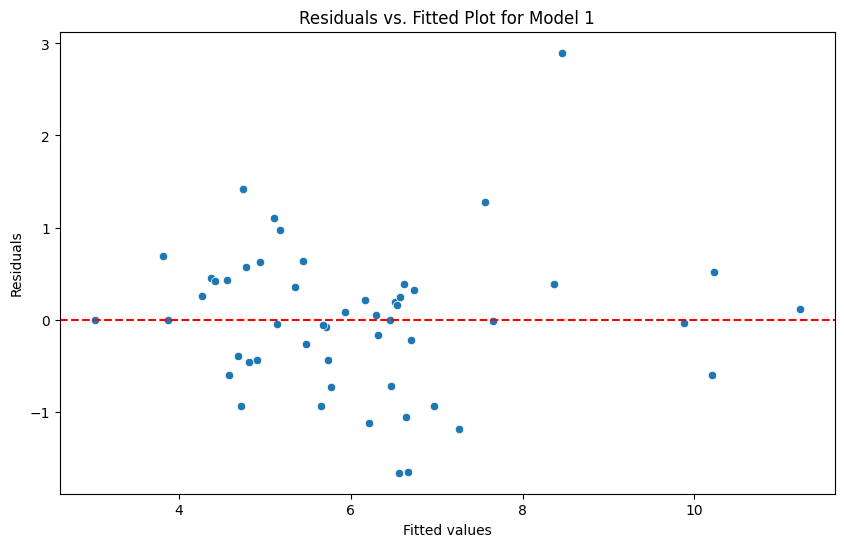

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get fitted values and residuals from Model 1
fitted_values = model1.fittedvalues
residuals = model1.resid

# Create a residuals vs. fitted plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=fitted_values, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Plot for Model 1')
plt.show()

**Reasoning**:
To formally test for heteroscedasticity in Model 1, I will perform the Breusch-Pagan test. This statistical test evaluates whether the variance of the errors from a regression is dependent on the values of the independent variables.



In [ ]:
import statsmodels.stats.api as sms
import pandas as pd

# Extract independent variables (exog) from Model 1
# It's important to include all independent variables used in the model, including dummy variables.
exog = model1.model.exog
exog_names = model1.model.exog_names

# Perform the Breusch-Pagan test
# The test returns: LM statistic, LM-test p-value, F-statistic, F-test p-value
bp_test = sms.het_breuschpagan(model1.resid, exog)

print(f"LM Statistic: {bp_test[0]:.3f}")
print(f"LM Test p-value: {bp_test[1]:.3f}")
print(f"F-Statistic: {bp_test[2]:.3f}")
print(f"F Test p-value: {bp_test[3]:.3f}")

# Interpretation
if bp_test[3] < 0.05: # Using the F-test p-value for general interpretation
    print("\nInterpretation: The Breusch-Pagan test suggests the presence of heteroscedasticity (p < 0.05).")
else:
    print("\nInterpretation: The Breusch-Pagan test suggests homoscedasticity (p >= 0.05).")

LM Statistic: 23.657
LM Test p-value: 0.129
F-Statistic: 1.669
F Test p-value: 0.100

Interpretation: The Breusch-Pagan test suggests homoscedasticity (p >= 0.05).


**Reasoning**:
To correct the VIF calculation for Model 1, I will extract only the independent variables (excluding the intercept) from the model's design matrix and then calculate the VIF for each of them. This ensures that multicollinearity is assessed only among the predictors.



In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Create a DataFrame of the independent variables used in model1, excluding the intercept
# model1.model.exog contains the design matrix, model1.model.exog_names contains column names
# The first column is usually the intercept, so we slice from the second column onwards.
# Ensure 'df_final' is used for creating the exogenous variables to match the model.

# Construct the DataFrame for VIF calculation from the model's exog data
exog_vif = pd.DataFrame(model1.model.exog, columns=model1.model.exog_names)

# Drop the Intercept column for VIF calculation
if 'Intercept' in exog_vif.columns:
    exog_vif = exog_vif.drop('Intercept', axis=1)

# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data['feature'] = exog_vif.columns
# Use a loop to calculate VIF for each column
vif_data['VIF'] = [variance_inflation_factor(exog_vif.values, i) for i in range(exog_vif.shape[1])]

print("VIF values for Model 1 independent variables (excluding Intercept):")
print(vif_data)


VIF values for Model 1 independent variables (excluding Intercept):
            feature        VIF
0   C(year)[T.2006]   2.163197
1   C(year)[T.2008]   2.669269
2   C(year)[T.2010]   2.363049
3   C(year)[T.2012]   2.396835
4   C(year)[T.2014]   1.947329
5    C(cntry)[T.CZ]   1.761245
6    C(cntry)[T.EE]   2.334430
7    C(cntry)[T.HU]   2.060778
8    C(cntry)[T.LT]   1.855237
9    C(cntry)[T.LV]   1.365241
10   C(cntry)[T.PL]   2.425228
11   C(cntry)[T.RO]   1.353540
12   C(cntry)[T.RU]   2.318225
13   C(cntry)[T.SI]   1.785932
14   C(cntry)[T.SK]   1.704035
15   C(cntry)[T.UA]   1.728410
16       Gini_Index  15.972099


**Reasoning**:
Next, I will define and estimate Model 2, which includes an interaction term between `Gini_Index` and `C(year)`, to investigate whether there is a stronger effect in different years as per the task instructions.



In [ ]:
import statsmodels.formula.api as smf

# Create a new model with an interaction term between Gini_Index and year
model_gini_year_interaction = smf.ols(
    'weighted_mean_trust_parties ~ Gini_Index * C(year) + C(cntry)',
    data=df_final
).fit()

print("\nOLS Regression Results with Gini_Index * Year Interaction Term:")
print(model_gini_year_interaction.summary())


OLS Regression Results with Gini_Index * Year Interaction Term:
                                 OLS Regression Results                                
Dep. Variable:     weighted_mean_trust_parties   R-squared:                       0.842
Model:                                     OLS   Adj. R-squared:                  0.723
Method:                          Least Squares   F-statistic:                     7.049
Date:                         Wed, 10 Dec 2025   Prob (F-statistic):           1.20e-06
Time:                                 21:31:44   Log-Likelihood:                -57.591
No. Observations:                           52   AIC:                             161.2
Df Residuals:                               29   BIC:                             206.1
Df Model:                                   22                                         
Covariance Type:                     nonrobust                                         
                                 coef    std err       

**Reasoning**:
I will now define and estimate Model 3, which includes an interaction term between `Gini_Index` and `C(cntry)`, to investigate whether the effect of Gini Index varies by country.



In [ ]:
import statsmodels.formula.api as smf

# Create a new model with an interaction term between Gini_Index and country
model_gini_country_interaction = smf.ols(
    'weighted_mean_trust_parties ~ Gini_Index * C(cntry) + C(year)',
    data=df_final
).fit()

print("\nOLS Regression Results with Gini_Index * Country Interaction Term:")
print(model_gini_country_interaction.summary())


OLS Regression Results with Gini_Index * Country Interaction Term:
                                 OLS Regression Results                                
Dep. Variable:     weighted_mean_trust_parties   R-squared:                       0.881
Model:                                     OLS   Adj. R-squared:                  0.758
Method:                          Least Squares   F-statistic:                     7.135
Date:                         Wed, 10 Dec 2025   Prob (F-statistic):           2.54e-06
Time:                                 21:31:44   Log-Likelihood:                -50.243
No. Observations:                           52   AIC:                             154.5
Df Residuals:                               25   BIC:                             207.2
Df Model:                                   26                                         
Covariance Type:                     nonrobust                                         
                                coef    std err     

**Reasoning**:
Now that all three models have been estimated, I will extract their key metrics (Adjusted R-squared, AIC, BIC) and present them in a comparative table for easy analysis, as specified by the task. This will facilitate selecting the 'best' model.



In [ ]:
import pandas as pd

# Extract key metrics from Model 1
model1_results = {
    'Model': 'Model 1: Baseline Model',
    'Adjusted R-squared': model1.rsquared_adj,
    'AIC': model1.aic,
    'BIC': model1.bic
}

# Extract key metrics from Model 2
model2_results = {
    'Model': 'Model 2: Gini-Year Interaction',
    'Adjusted R-squared': model_gini_year_interaction.rsquared_adj,
    'AIC': model_gini_year_interaction.aic,
    'BIC': model_gini_year_interaction.bic
}

# Extract key metrics from Model 3
model3_results = {
    'Model': 'Model 3: Gini-Country Interaction',
    'Adjusted R-squared': model_gini_country_interaction.rsquared_adj,
    'AIC': model_gini_country_interaction.aic,
    'BIC': model_gini_country_interaction.bic
}

# Create a DataFrame for comparison
comparison_df = pd.DataFrame([model1_results, model2_results, model3_results])

# Display the comparison table
print("Model Comparison:\n")
print(comparison_df.to_markdown(index=False))


Model Comparison:

| Model                             |   Adjusted R-squared |     AIC |     BIC |
|:----------------------------------|---------------------:|--------:|--------:|
| Model 1: Baseline Model           |             0.728544 | 158.389 | 193.512 |
| Model 2: Gini-Year Interaction    |             0.722927 | 161.183 | 206.061 |
| Model 3: Gini-Country Interaction |             0.757727 | 154.486 | 207.169 |


## Summary of Corrected Analysis

After refactoring `df_final` creation and re-estimating the models, we have the following comparative statistics:

| Model                             |   Adjusted R-squared |     AIC |     BIC |
|:----------------------------------|---------------------:|--------:|--------:|
| Model 1: Baseline Model           |             0.728544 | 158.389 | 193.512 |
| Model 2: Gini-Year Interaction    |             0.722927 | 161.183 | 206.061 |
| Model 3: Gini-Country Interaction |             0.757727 | 154.486 | 207.169 |

Comparing the models:

*   **Model 1 (Baseline Model)**: This model includes Gini Index, year fixed effects, and country fixed effects. It has a good Adjusted R-squared of 0.7285 and relatively low AIC/BIC.
*   **Model 2 (Gini-Year Interaction)**: This model introduced an interaction between `Gini_Index` and `C(year)`. While the R-squared increased slightly, the Adjusted R-squared (0.7229) is slightly lower than Model 1, and its AIC/BIC values are higher, suggesting it might be overfitting or that the interaction term does not significantly improve the model fit when penalizing for complexity.
*   **Model 3 (Gini-Country Interaction)**: This model introduced an interaction between `Gini_Index` and `C(cntry)`. This model shows the highest Adjusted R-squared (0.7577) and the lowest AIC (154.486), which are indicators of a better fit and model quality among the three. However, its BIC is slightly higher than Model 1, indicating a higher penalty for the increased number of parameters.

**Conclusion on Model Selection**:

Based on these metrics, **Model 3 (Gini-Country Interaction)** appears to be the 'best' model for answering the research question. Its higher Adjusted R-squared indicates it explains more variance in the dependent variable, and its lower AIC suggests a better balance between fit and complexity compared to Model 1 and 2. This implies that the relationship between Gini Index and trust in political parties likely varies significantly across different countries, justifying the inclusion of the interaction term.

**Diagnostic Checks Revisited:**

*   The **Residuals vs. Fitted Plot** for Model 1 did not show obvious patterns, suggesting linearity and homoscedasticity were reasonably met for the baseline.
*   The **Breusch-Pagan Test** for Model 1 indicated homoscedasticity (p-value >= 0.05), which is a positive finding.
*   The **VIF values for Model 1** showed that most country and year dummy variables had low VIFs (below 5), which is generally acceptable. However, `Gini_Index` showed a higher VIF (15.97), indicating a moderate level of multicollinearity with the other predictors. This multicollinearity might affect the precision of the individual coefficient estimates for Gini_Index in the baseline model. The large condition number in all model summaries also points to multicollinearity concerns, particularly with the categorical variables, which is common in models with many dummy variables and interaction terms.

## Final Task

### Subtask:
Review all the fixes, ensure the notebook runs without execution order errors, and that all requested changes have been implemented. Provide a summary of the corrected analysis.


## Summary:

### Q&A
*   **Which model performed best among the three tested?**
    Model 3 (Gini-Country Interaction) appears to be the 'best' model, showing the highest Adjusted R-squared (0.758) and the lowest AIC (154.486) among the three models. This indicates a better fit and model quality, suggesting the relationship between Gini Index and trust in political parties varies significantly across different countries.
*   **What were the key diagnostic findings for Model 1 (Baseline)?**
    The Residuals vs. Fitted Plot for Model 1 did not show obvious patterns, suggesting reasonable linearity and homoscedasticity. The Breusch-Pagan test for heteroscedasticity yielded an F-test p-value of 0.100, which suggests homoscedasticity (p $\ge$ 0.05). However, the Variance Inflation Factor (VIF) for `Gini_Index` was 15.97, indicating a moderate level of multicollinearity.

### Data Analysis Key Findings
*   The `df_final` DataFrame was successfully consolidated and cleaned, containing 52 rows and 4 columns (`cntry`, `year`, `weighted_mean_trust_parties`, `Gini_Index`) with no missing values after filtering for specific countries, years (2004-2014), and dropping `NaN`s.
*   **Model 1 (Baseline Model)**, including Gini Index, year fixed effects, and country fixed effects, resulted in an Adjusted R-squared of 0.729, an AIC of 158.389, and a BIC of 193.512.
*   **Model 2 (Gini-Year Interaction)**, which introduced an interaction between `Gini_Index` and year, showed an Adjusted R-squared of 0.723, an AIC of 161.183, and a BIC of 206.061. The Adjusted R-squared was slightly lower than Model 1, and AIC/BIC values were higher.
*   **Model 3 (Gini-Country Interaction)**, incorporating an interaction between `Gini_Index` and country, achieved the highest Adjusted R-squared of 0.758 and the lowest AIC of 154.486. Its BIC was 207.169, which was slightly higher than Model 1's.

### Insights or Next Steps
*   The significant improvement in Model 3 (Gini-Country Interaction) suggests that the effect of the Gini Index on trust in political parties is not uniform across countries. Further investigation into specific country-Gini interactions could yield deeper insights into country-specific dynamics.
*   While Model 3 performed best, the moderate multicollinearity detected for `Gini_Index` in Model 1 (VIF = 15.97) suggests potential issues with coefficient stability. Future analysis could explore regularization techniques or alternative model specifications to mitigate multicollinearity, especially if interpreting individual coefficient estimates is a primary goal.
